# Drowsiness Detection System

- Drowsy Driving is a deadly combination of driving and sleepiness.

- The number of road accidents due to Drowsy Driving is increasing at an alarming rate worldwide.

- Not having a proper sleep is the main reason behind drowsiness while driving. However, other reasons like sleep disorders, medication, alcohol consumption, or driving during night shifts can also cause drowsiness while driving.


# Loading data and libraries

In [7]:
!pip install opencv-python

In [9]:
import sys
print(sys.executable)


/usr/bin/python3


In [11]:
!pip install mediapipe
import pandas as pd
import numpy as np
import mediapipe as mp
import os
import shutil
import matplotlib.pyplot as plt
import mediapipe as mp

mp_facemesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates

%matplotlib inline

In [12]:
os.makedirs('./Fatigue Subjects')
os.makedirs('./Active Subjects')

# Image preprocessing :
### our preprocessing will include
- Detecting faces from images
- Drawing landmarks on our images to increase performance
- Resizing our images
- LabelEncoding
- Image Augmantation

# Landmarks :
We will use mediapipe to draw landmarks on our images after detecting faces and croping them

In [17]:
# Landmark points corresponding to left eye
all_left_eye_idxs = list(mp_facemesh.FACEMESH_LEFT_EYE)
# flatten and remove duplicates
all_left_eye_idxs = set(np.ravel(all_left_eye_idxs))

# Landmark points corresponding to right eye
all_right_eye_idxs = list(mp_facemesh.FACEMESH_RIGHT_EYE)
all_right_eye_idxs = set(np.ravel(all_right_eye_idxs))

# Combined for plotting - Landmark points for both eye
all_idxs = all_left_eye_idxs.union(all_right_eye_idxs)

# The chosen 12 points:   P1,  P2,  P3,  P4,  P5,  P6
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]
all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

In [18]:
IMG_SIZE=145
i=0
def draw(
    *,n=i,
    img_dt,cat,
    img_eye_lmks=None,
    img_eye_lmks_chosen=None,
    face_landmarks=None,
    ts_thickness=1,
    ts_circle_radius=2,
    lmk_circle_radius=3,
    name="1",
):
    # For plotting Face Tessellation
    image_drawing_tool = img_dt

     # For plotting all eye landmarks
    image_eye_lmks = img_dt.copy() if img_eye_lmks is None else img_eye_lmks

    # For plotting chosen eye landmarks
    img_eye_lmks_chosen = img_dt.copy() if img_eye_lmks_chosen is None else img_eye_lmks_chosen

    # Initializing drawing utilities for plotting face mesh tessellation
    connections_drawing_spec = mp_drawing.DrawingSpec(
        thickness=ts_thickness,
        circle_radius=ts_circle_radius,
        color=(255, 255, 255)
    )


    # Draw landmarks on face using the drawing utilities.
    mp_drawing.draw_landmarks(
        image=image_drawing_tool,
        landmark_list=face_landmarks,
        connections=mp_facemesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=connections_drawing_spec,
    )

    # Get the object which holds the x, y, and z coordinates for each landmark
    landmarks = face_landmarks.landmark

    # Iterate over all landmarks.
    # If the landmark_idx is present in either all_idxs or all_chosen_idxs,
    # get the denormalized coordinates and plot circles at those coordinates.

    for landmark_idx, landmark in enumerate(landmarks):
        if landmark_idx in all_idxs:
            pred_cord = denormalize_coordinates(landmark.x,
                                                landmark.y,
                                                imgW, imgH)
            cv2.circle(image_eye_lmks,
                       pred_cord,
                       lmk_circle_radius,
                       (255, 255, 255),
                       -1
                       )

        if landmark_idx in all_chosen_idxs:
            pred_cord = denormalize_coordinates(landmark.x,
                                                landmark.y,
                                                imgW, imgH)
            cv2.circle(img_eye_lmks_chosen,
                       pred_cord,
                       lmk_circle_radius,
                       (255, 255, 255),
                       -1
                       )

    if cat=='Fatigue Subjects':
        cv2.imwrite(str('./Fatigue Subjects/'+str(n)+'.jpg'), image_drawing_tool)
    else:
        cv2.imwrite(str('./Active Subjects/'+str(n)+'.jpg'), image_drawing_tool)

    resized_array = cv2.resize(image_drawing_tool, (IMG_SIZE, IMG_SIZE))
    return resized_array

In [21]:
imgH, imgW, _=0,0,0
def landmarks(image,category,i):
    resized_array=[]
    IMG_SIZE = 145
    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape

     # Running inference using static_image_mode
    with mp_facemesh.FaceMesh(
        static_image_mode=True,         # Default=False
        max_num_faces=1,                # Default=1
        refine_landmarks=False,         # Default=False
        min_detection_confidence=0.5,   # Default=0.5
        min_tracking_confidence= 0.5,) as face_mesh:

        results = face_mesh.process(image)

        # If detections are available.
        if results.multi_face_landmarks:
            for face_id, face_landmarks in enumerate(results.multi_face_landmarks):
                resized_array= draw(img_dt=image.copy(), cat=category, n=i,face_landmarks=face_landmarks)
    return resized_array

In [22]:
def face_for_yawn(direc="../input/drowsiness-prediction-dataset/0 FaceImages", face_cas_path="../input/prediction-images/haarcascade_frontalface_default.xml"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                land_face_array=landmarks(roi_color,category,i)
                yaw_no.append([land_face_array, class_num1])
                i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

0
1


In [23]:
dir_path = r'./Active Subjects'
print("Number of Active images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Active images :
3869


In [24]:
dir_path = r'./Fatigue Subjects'
print("Number of Fatigue images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Fatigue images :
3669


### Our images will be like this:

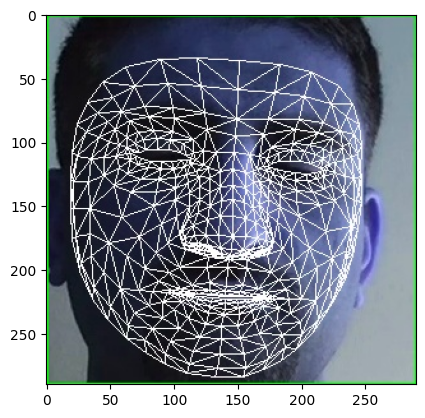

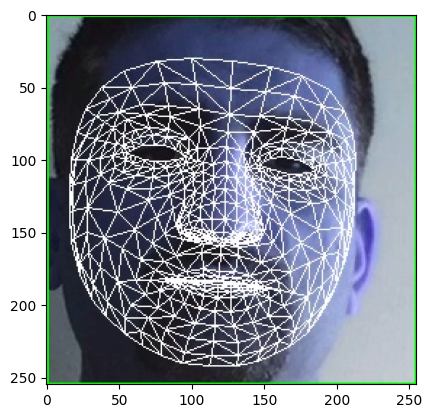

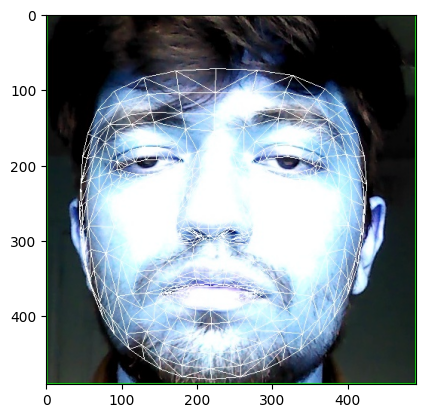

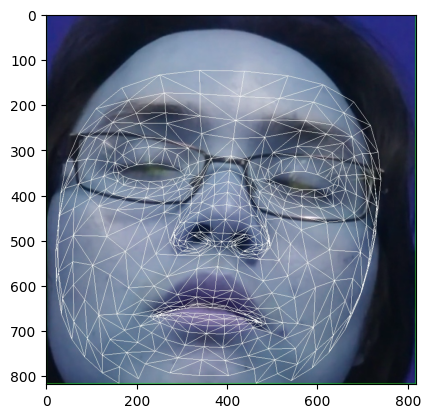

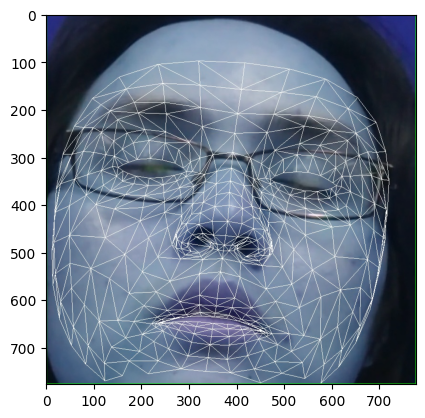

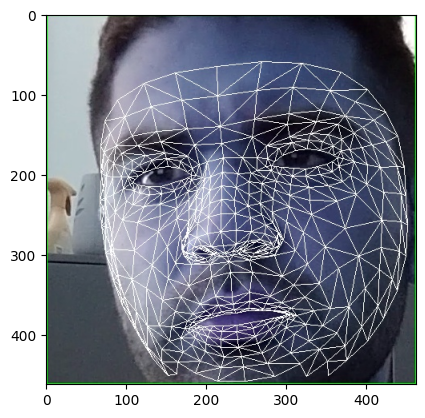

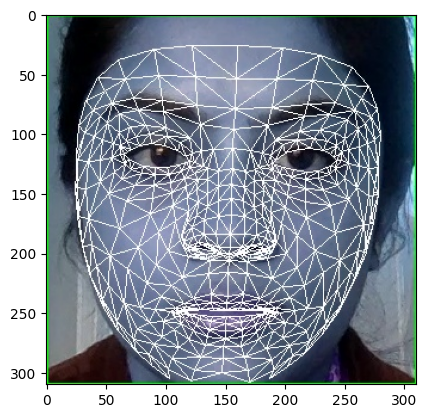

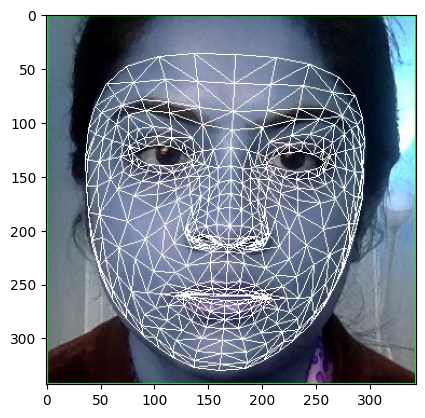

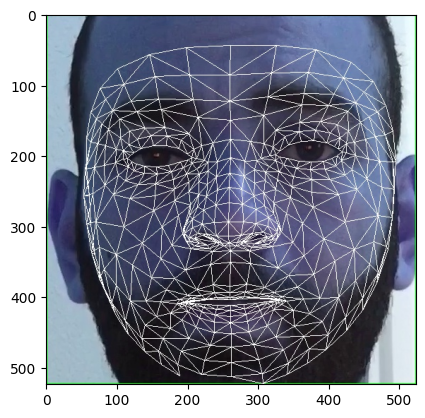

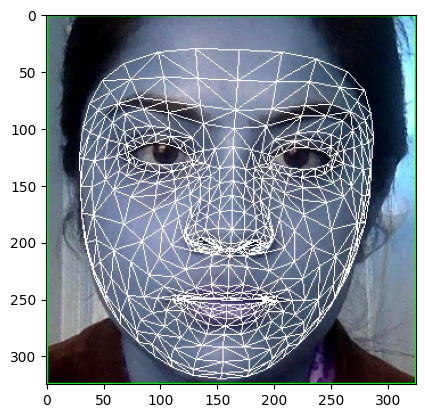

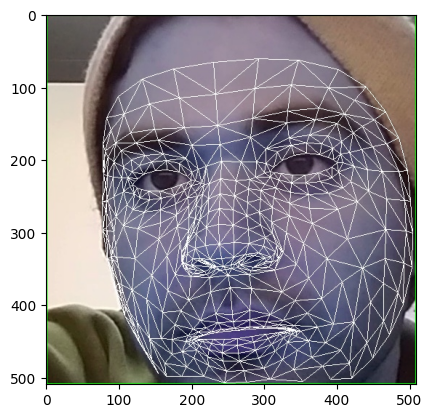

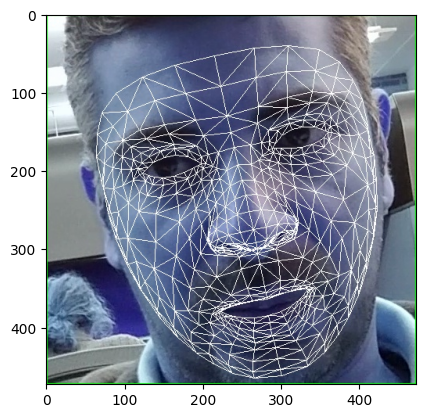

In [25]:
categories = ["Fatigue Subjects", "Active Subjects"]
for category in categories:
  for idx, img in enumerate(os.listdir(f'./{category}')):
      if idx > 5:
        break
      img_file = cv2.imread(f'./{category}/{img}')
      plt.imshow(img_file)
      plt.show()
      plt.close()

### Resizing images

In [26]:
import os
import time
def face_for_yawn(direc="./"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            resized_array = cv2.resize(image_array, (IMG_SIZE, IMG_SIZE))
            yaw_no.append([resized_array, class_num1])
                #print('image face number '+str(i))
                #i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

0
1


## separate label and features

In [27]:
X = []
y = []
for feature, label in yawn_no_yawn:
    X.append(feature)
    y.append(label)

## Reshape the array

In [28]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

## LabelEncoder

In [29]:
from sklearn.preprocessing import LabelEncoder
label_bin = LabelEncoder()
y = label_bin.fit_transform(y)
y = np.array(y)

# Splitting

In [30]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [31]:
len(X_test)

1508

In [32]:
len(X_train)

6030

### import some dependencies

In [33]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Data Augmentation

In [34]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [35]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define input layer
input_layer = Input(shape=X_train.shape[1:])

# First convolutional layer
conv1 = Conv2D(16, 3, activation='relu')(input_layer)
conv1 = BatchNormalization()(conv1)
conv1 = MaxPooling2D()(conv1)
conv1 = Dropout(0.1)(conv1)

# Second convolutional layer
conv2 = Conv2D(32, 5, activation='relu')(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = MaxPooling2D()(conv2)
conv2 = Dropout(0.1)(conv2)

# Third convolutional layer
conv3 = Conv2D(64, 10, activation='relu')(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = MaxPooling2D()(conv3)
conv3 = Dropout(0.1)(conv3)

# Fourth convolutional layer
conv4 = Conv2D(128, 12, activation='relu')(conv3)
conv4 = BatchNormalization()(conv4)

# Flatten the output
flatten = Flatten()(conv4)

# Dense layers
dense1 = Dense(128, activation='relu')(flatten)
dense1 = Dropout(0.25)(dense1)
dense2 = Dense(64, activation='relu')(dense1)

# Output layer
output_layer = Dense(1, activation='sigmoid')(dense2)

# Create model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")

# Print model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 145, 145, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 143, 143, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 143, 143, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 71, 71, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 71, 71, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 67, 67, 32)        12832 

In [36]:
history = model.fit(train_generator, epochs=70, validation_data=test_generator)

Epoch 1/70
189/189 [==============================] - 50s 204ms/step - loss: 0.5386 - accuracy: 0.7212 - val_loss: 5.1304 - val_accuracy: 0.5053
Epoch 2/70
189/189 [==============================] - 38s 203ms/step - loss: 0.4573 - accuracy: 0.7814 - val_loss: 1.1882 - val_accuracy: 0.5066
Epoch 3/70
189/189 [==============================] - 37s 193ms/step - loss: 0.4197 - accuracy: 0.7962 - val_loss: 0.7610 - val_accuracy: 0.6538
Epoch 4/70
189/189 [==============================] - 37s 196ms/step - loss: 0.3777 - accuracy: 0.8201 - val_loss: 0.4848 - val_accuracy: 0.7964
Epoch 5/70
189/189 [==============================] - 36s 192ms/step - loss: 0.3309 - accuracy: 0.8459 - val_loss: 0.3785 - val_accuracy: 0.8375
Epoch 6/70
189/189 [==============================] - 37s 196ms/step - loss: 0.2932 - accuracy: 0.8697 - val_loss: 0.4005 - val_accuracy: 0.8210
Epoch 7/70
189/189 [==============================] - 37s 194ms/step - loss: 0.2708 - accuracy: 0.8779 - val_loss: 0.3209 - val_ac

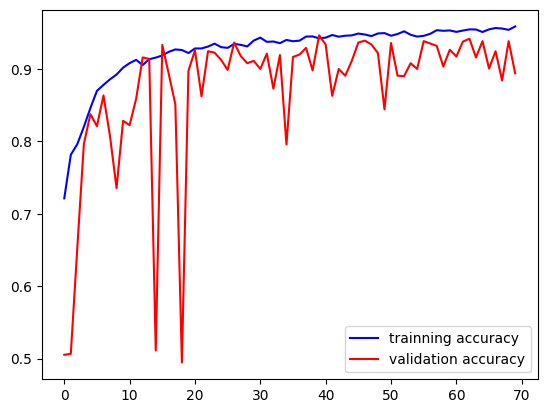

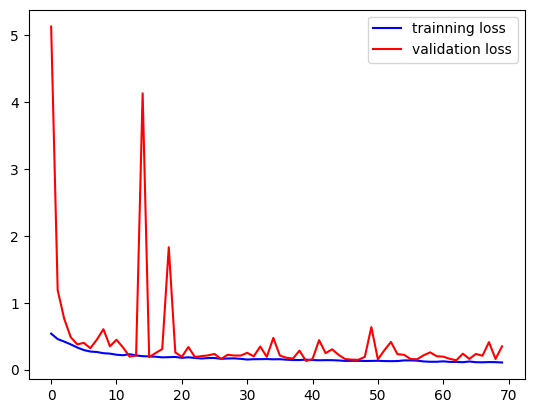

In [37]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [38]:
# You can evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_generator)
dict(zip(model.metrics_names, result))

Evaluate
48/48 [==============================] - 1s 12ms/step - loss: 0.3489 - accuracy: 0.8939


{'loss': 0.3488651216030121, 'accuracy': 0.8938992023468018}

In [41]:
model.save('my_model.h5')
#model = tf.keras.models.load_model('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


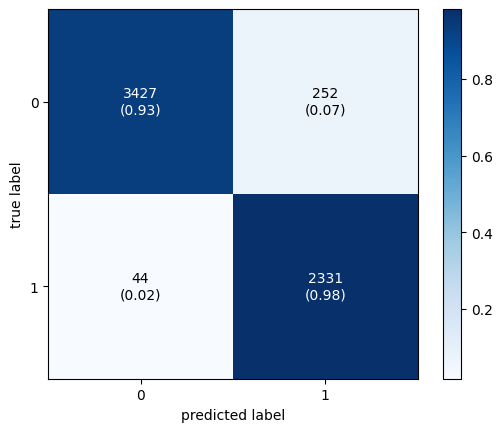

In [42]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plot_confusion_matrix(conf_mat=binary1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [43]:
!pip install tensorflow

In [44]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras.utils import plot_model

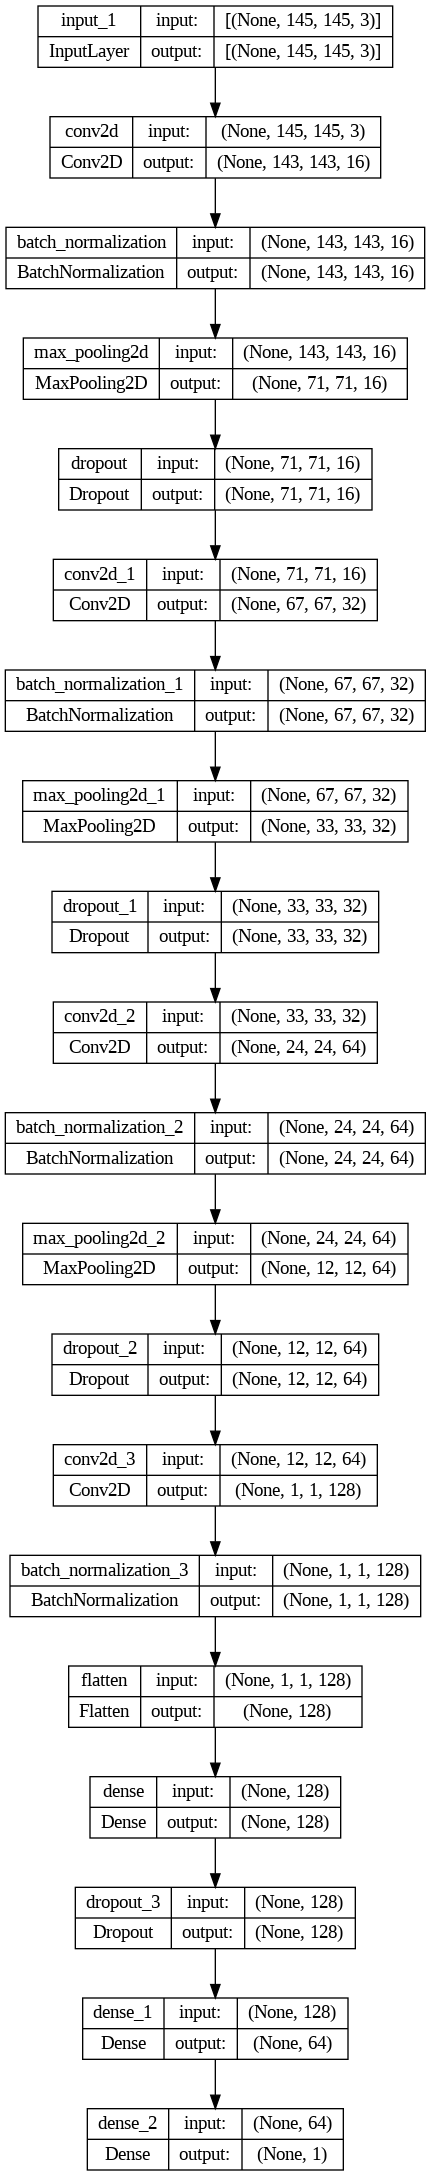

In [45]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image("model.png")

# Visualizing our CNN architecture

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 6.0 MB/s eta 0:00:00


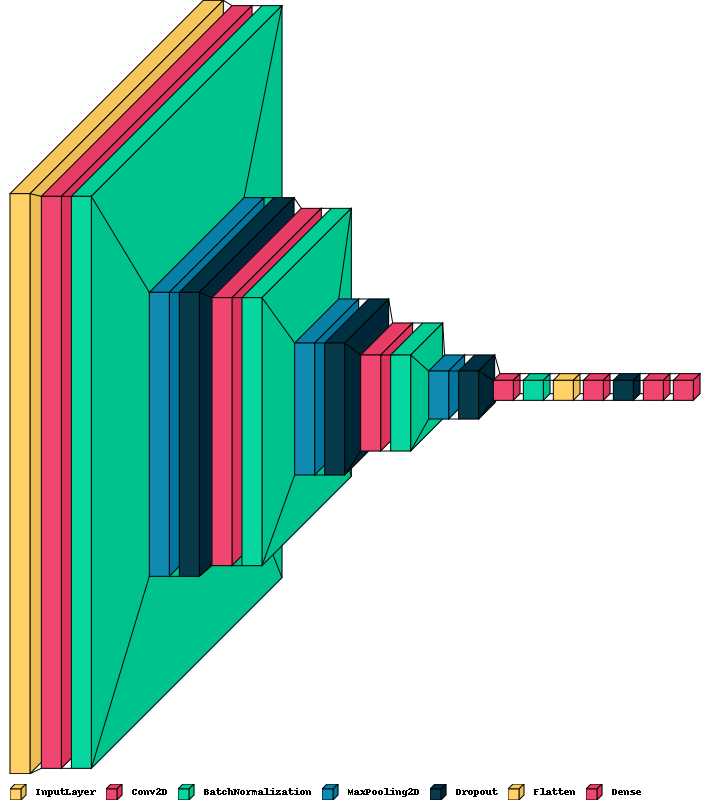

In [46]:
!pip install visualkeras
import visualkeras

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model,legend=True)

In [ ]:
# output for user input image
import numpy as np
import cv2
IMG_SIZE = 145
image_path = "/a0002.png"
image = cv2.imread(image_path)
resized_array = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
resized_array = np.expand_dims(resized_array, axis=0)
prediction = model.predict(resized_array)
if prediction[0] == 0:
  print("Active")
else:
  print("Fatigue")


1/1 [==============================] - 1s 525ms/step
Fatigue


### Evaluiation Metrics

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

48/48 [==============================] - 1s 9ms/step
Accuracy: 0.7314323607427056
Precision: 0.7012401352874859
Recall: 0.8162729658792651
F1-score: 0.7543966040024257
Confusion Matrix:
[[481 265]
 [140 622]]
